<h1> Batch Dimensions and Visualization </h1>

0 : torch.Size([5, 40, 128, 128])
1 : torch.Size([5, 40, 128, 128])
2 : torch.Size([5, 40, 128, 128])
3 : torch.Size([5, 40, 128, 128])
4 : torch.Size([4, 40, 128, 128])


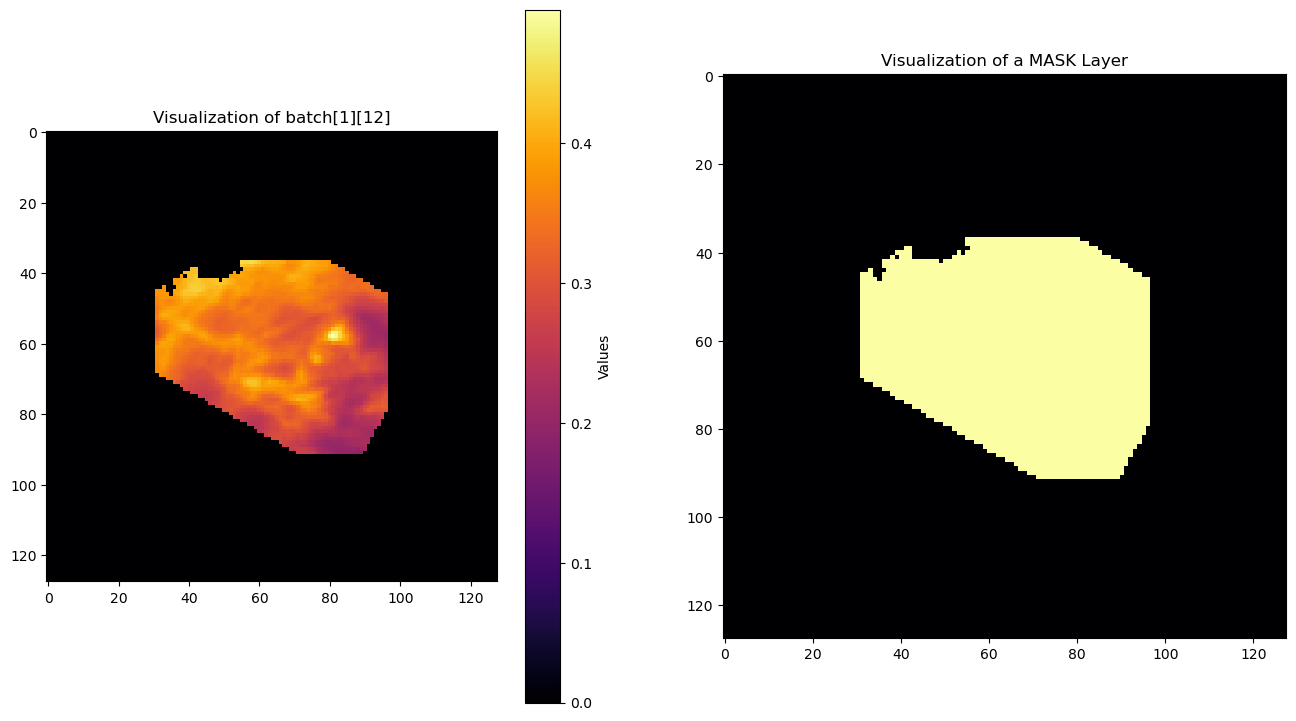

In [58]:
import matplotlib.pyplot as plt
from utils import TrajectoryDataset
from torch.utils.data import DataLoader
from pathlib import Path
# See Train Dimensions
PATH = Path('.')
window= 10
batch_size = 5


trainset = TrajectoryDataset(PATH / 'data/train.h5', window=window, flatten=True)
validset = TrajectoryDataset(PATH / 'data/valid.h5', window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

plot_batch = None
for i, (batch, _) in  enumerate(trainloader):
    print(f"{i} : {batch.shape}")
    plot_batch = batch



# Plot
# Choose random batch[i,j, :, :]
i = torch.randint(0,4,(1,))
j = torch.randint(0,40, (1,))
if (j+1) % 4 == 0 and j != 0:
    j = j -1

figure, axis = plt.subplots(1,2, figsize=(16,9))
im = axis[0].imshow(batch[i[0],j[0]],  cmap='inferno')
axis[0].set_title(f"Visualization of batch[{i[0]}][{j[0]}]")
figure.colorbar(mappable = im,label='Values')
axis[1].imshow(batch[0,7],  cmap='inferno')
axis[1].set_title(f"Visualization of a MASK Layer")

plt.show()


<h1> Understand UNET dimensions </h1>

In [17]:

import torch
import torch.nn as nn
from nn import UNet

in_channels = 4
out_channels = 4
mod_features = 66
hidden_channels = [32, 64, 128]
hidden_blocks = [2, 3, 5]
spatial = 2

# UNET Forward : x (B, C, H, W)
unet = UNet(
    in_channels=in_channels,
    out_channels=out_channels,
    mod_features=mod_features,
    hidden_channels=hidden_channels,
    hidden_blocks=hidden_blocks,
    spatial=spatial,
)


batch_size = 4
x = torch.randn(batch_size, in_channels, 128, 128)


y = torch.randn(batch_size, mod_features)


output = unet(x, y)


print(output.shape)

torch.Size([4, 4, 128, 128])


<h1> Understand ScoreUNET dimensions </h1>

In [18]:
import torch
import torch.nn as nn
from score import ScoreUNet
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }


score_unet = ScoreUNet(**CONFIG)




x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # because of flatten
t = torch.rand(x.shape[0], dtype=x.dtype, device=x.device)

print(f"x:  {x.shape} , t: {t.shape}")
c = None

# Forward pass through the ScoreUNet
output = score_unet(x, t, c)

# Print the output shape
print(f"Output Shape : {output.shape}")  # Should be (batch_size, channels, x, y)

x:  torch.Size([5, 40, 128, 128]) , t: torch.Size([5])
Output Shape : torch.Size([5, 40, 128, 128])


<h1> Understand VPSDE dimensions </h1>

In [19]:
import torch
import torch.nn as nn
from score import ScoreUNet, VPSDE

batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64,\
}


score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))



x = torch.randn([batch_size, window*MAR_channels, y_dim, x_dim]) # window*MAR_channels because of flatten

vpsde.loss(x)

tensor(1.2992, grad_fn=<MeanBackward0>)

<h1> Batch Loop (Ensure Architecture design is well shaped)</h1>

In [20]:
import torch
import h5py
import torch.nn as nn
from score import ScoreUNet, VPSDE

# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

'''
 Batch loop
'''
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=1, persistent_workers=True)
for i, (batch, _) in enumerate(trainloader):
        loss = vpsde.loss(batch, w=mask)
        print(f"{i} batch : {batch.shape}, loss : {loss}")

0 batch : torch.Size([5, 40, 128, 128]), loss : 1.207022786140442
1 batch : torch.Size([5, 40, 128, 128]), loss : 1.2242865562438965
2 batch : torch.Size([5, 40, 128, 128]), loss : 1.2292450666427612
3 batch : torch.Size([5, 40, 128, 128]), loss : 1.2149744033813477
4 batch : torch.Size([4, 40, 128, 128]), loss : 1.2173360586166382


<h1> CPU Training Loop </h1>

In [7]:
import os
import h5py
import math
import torch
import numpy as np
#import wandb
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import trange
from pathlib import Path
from utils import TrajectoryDataset
from score import ScoreUNet, MCScoreWrapper, VPSDE
from score import VPSDE

PATH = Path('.')

with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32).unsqueeze(0)  # Shape

if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")

TRAIN_CONFIG = {
    "epochs": 100,
    "batch_size": 5,
    "learning_rate": 1e-3,
    "weight_decay": 1e-3,
    "scheduler": "linear",  # Can be "cosine" or "exponential"
    "embedding": 32,
    "hidden_channels": (64,),
    "hidden_blocks": (3,),
    "activation": "SiLU",
}
device = 'cpu'

'''
Definition of Denoiser and Scheduler
'''
# Common dimensions
batch_size = 5
MAR_channels = 4 # Example ['RF', 'T2m', 'U10m', MASK]
window = 10
y_dim = 128
x_dim = 128

# Define the network
MODEL_CONFIG = { 'hidden_channels' : [32, 64, 128],  \
'hidden_blocks' : [2, 3, 5],  \
'spatial' : 2, \
'channels' : window*MAR_channels, \
'context' : 0,\
'embedding' : 64 }

# Denoiser and Scheduler
score_unet = ScoreUNet(**MODEL_CONFIG)
vpsde = VPSDE(score_unet, shape=(MAR_channels*window, y_dim, x_dim))

# Load Dataset
trainset = TrajectoryDataset(PATH / "data/train.h5", window=10, flatten=True)
validset = TrajectoryDataset(PATH / "data/valid.h5", window=10, flatten=True)

trainloader = DataLoader(trainset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=TRAIN_CONFIG["batch_size"], shuffle=False, num_workers=1, persistent_workers=True)


optimizer = optim.AdamW(vpsde.parameters(), lr=TRAIN_CONFIG["learning_rate"], weight_decay=TRAIN_CONFIG["weight_decay"])

# Define Learning Rate Scheduler
if TRAIN_CONFIG["scheduler"] == "linear":
    lr_lambda = lambda t: 1 - (t / TRAIN_CONFIG["epochs"])
elif TRAIN_CONFIG["scheduler"] == "cosine":
    lr_lambda = lambda t: (1 + math.cos(math.pi * t / TRAIN_CONFIG["epochs"])) / 2
elif TRAIN_CONFIG["scheduler"] == "exponential":
    lr_lambda = lambda t: math.exp(-7 * (t / TRAIN_CONFIG["epochs"]) ** 2)
else:
    raise ValueError("Invalid scheduler type")

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# Lists to store loss history
all_losses_train = []
all_losses_valid = []
for epoch in (bar := trange(TRAIN_CONFIG["epochs"], ncols=88)):
    losses_train = []
    losses_valid = []

    # Training
    vpsde.train()
    for i, (batch, _) in enumerate(trainloader):
        if torch.isnan(batch).any():
            raise ValueError("batch contains NaN values!")
        batch = batch.to(device)
        optimizer.zero_grad()

        # Mask
        mask_batch = mask.to(device).expand_as(batch)  # Expand mask to match batch size
        w = mask_batch.float()  # Convert mask to weight format


        loss = vpsde.loss(batch, w=w)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach())

    # Evaluation
    vpsde.eval()
    with torch.no_grad():
        for batch, _ in validloader:
            batch = batch.to(device)
            mask_batch = mask.to(device).expand_as(batch)
            w = mask_batch.float()

            loss = vpsde.loss(batch, w=w)
            losses_valid.append(loss)

    loss_train = torch.stack(losses_train).mean().item()
    loss_valid = torch.stack(losses_valid).mean().item()
    print(f"Train Loss : {loss_train}, Valid Loss : {loss_valid}")
    lr = optimizer.param_groups[0]['lr']

    all_losses_train.append(loss_train)
    all_losses_valid.append(loss_valid)
    ## Step Scheduler
    scheduler.step()

  1%|▌                                                  | 1/100 [00:05<09:41,  5.88s/it]

Train Loss : 1.2745401859283447, Valid Loss : 1.0667407512664795


  2%|█                                                  | 2/100 [00:11<09:12,  5.63s/it]

Train Loss : 1.0591509342193604, Valid Loss : 1.0155956745147705


  3%|█▌                                                 | 3/100 [00:16<08:40,  5.36s/it]

Train Loss : 1.0046287775039673, Valid Loss : 0.9672130942344666


  4%|██                                                 | 4/100 [00:20<08:05,  5.05s/it]

Train Loss : 0.9556748270988464, Valid Loss : 0.920330822467804


  5%|██▌                                                | 5/100 [00:25<07:39,  4.84s/it]

Train Loss : 0.9228342175483704, Valid Loss : 0.8733131885528564


  6%|███                                                | 6/100 [00:30<07:30,  4.79s/it]

Train Loss : 0.89228355884552, Valid Loss : 0.8644734621047974


  7%|███▌                                               | 7/100 [00:34<07:17,  4.71s/it]

Train Loss : 0.854178249835968, Valid Loss : 0.8605125546455383


  8%|████                                               | 8/100 [00:39<07:06,  4.63s/it]

Train Loss : 0.8251398801803589, Valid Loss : 0.8406863212585449


  9%|████▌                                              | 9/100 [00:43<07:04,  4.66s/it]

Train Loss : 0.7811353206634521, Valid Loss : 0.7739511728286743


 10%|█████                                             | 10/100 [00:48<06:53,  4.59s/it]

Train Loss : 0.762305736541748, Valid Loss : 0.8462353944778442


 11%|█████▌                                            | 11/100 [00:52<06:44,  4.55s/it]

Train Loss : 0.7693156003952026, Valid Loss : 0.6789976358413696


 12%|██████                                            | 12/100 [00:57<06:48,  4.64s/it]

Train Loss : 0.745306134223938, Valid Loss : 0.7601411938667297


 13%|██████▌                                           | 13/100 [01:02<06:38,  4.58s/it]

Train Loss : 0.6807199716567993, Valid Loss : 0.6990561485290527


 14%|███████                                           | 14/100 [01:06<06:32,  4.56s/it]

Train Loss : 0.6885302662849426, Valid Loss : 0.6127421259880066


 15%|███████▌                                          | 15/100 [01:11<06:27,  4.55s/it]

Train Loss : 0.6417092084884644, Valid Loss : 0.6020876169204712


 16%|████████                                          | 16/100 [01:15<06:22,  4.56s/it]

Train Loss : 0.6363048553466797, Valid Loss : 0.6056969165802002


 17%|████████▌                                         | 17/100 [01:20<06:18,  4.56s/it]

Train Loss : 0.6315367221832275, Valid Loss : 0.5999254584312439


 18%|█████████                                         | 18/100 [01:24<06:12,  4.55s/it]

Train Loss : 0.6223680377006531, Valid Loss : 0.8252372741699219


 19%|█████████▌                                        | 19/100 [01:29<06:07,  4.54s/it]

Train Loss : 0.5911992788314819, Valid Loss : 0.6697636842727661


 20%|██████████                                        | 20/100 [01:34<06:13,  4.67s/it]

Train Loss : 0.5959588289260864, Valid Loss : 0.5515469312667847


 21%|██████████▌                                       | 21/100 [01:39<06:13,  4.73s/it]

Train Loss : 0.5662304162979126, Valid Loss : 0.5240301489830017


 22%|███████████                                       | 22/100 [01:43<06:09,  4.74s/it]

Train Loss : 0.5810691714286804, Valid Loss : 0.5236725211143494


 23%|███████████▌                                      | 23/100 [01:48<06:10,  4.81s/it]

Train Loss : 0.5486658811569214, Valid Loss : 0.4964907765388489


 24%|████████████                                      | 24/100 [01:53<06:00,  4.75s/it]

Train Loss : 0.5158512592315674, Valid Loss : 0.6556286215782166


 25%|████████████▌                                     | 25/100 [01:58<05:55,  4.75s/it]

Train Loss : 0.5323489308357239, Valid Loss : 0.5063943862915039


 26%|█████████████                                     | 26/100 [02:02<05:45,  4.68s/it]

Train Loss : 0.5099931955337524, Valid Loss : 0.7660872936248779


 27%|█████████████▌                                    | 27/100 [02:07<05:45,  4.73s/it]

Train Loss : 0.5076745748519897, Valid Loss : 0.4575549364089966


 28%|██████████████                                    | 28/100 [02:12<05:41,  4.74s/it]

Train Loss : 0.470872163772583, Valid Loss : 0.5484253764152527


 29%|██████████████▍                                   | 29/100 [02:16<05:35,  4.73s/it]

Train Loss : 0.5077639222145081, Valid Loss : 0.439321905374527


 30%|███████████████                                   | 30/100 [02:21<05:25,  4.66s/it]

Train Loss : 0.4459131360054016, Valid Loss : 0.43098029494285583


 31%|███████████████▌                                  | 31/100 [02:26<05:32,  4.82s/it]

Train Loss : 0.5167237520217896, Valid Loss : 0.4302135705947876


 32%|████████████████                                  | 32/100 [02:31<05:24,  4.77s/it]

Train Loss : 0.5182105898857117, Valid Loss : 0.8510995507240295


 33%|████████████████▌                                 | 33/100 [02:35<05:16,  4.73s/it]

Train Loss : 0.5022058486938477, Valid Loss : 0.4767110049724579


 34%|█████████████████                                 | 34/100 [02:40<05:08,  4.67s/it]

Train Loss : 0.47926101088523865, Valid Loss : 0.513870120048523


 35%|█████████████████▌                                | 35/100 [02:45<05:02,  4.66s/it]

Train Loss : 0.5010887384414673, Valid Loss : 0.6445139050483704


 36%|██████████████████                                | 36/100 [02:49<04:59,  4.67s/it]

Train Loss : 0.46324795484542847, Valid Loss : 0.5185423493385315


 37%|██████████████████▌                               | 37/100 [02:54<04:52,  4.65s/it]

Train Loss : 0.4595869183540344, Valid Loss : 0.4147762954235077


 38%|███████████████████                               | 38/100 [02:59<04:52,  4.71s/it]

Train Loss : 0.45201435685157776, Valid Loss : 0.5941027402877808


 39%|███████████████████▌                              | 39/100 [03:04<04:47,  4.71s/it]

Train Loss : 0.43349209427833557, Valid Loss : 0.6143525838851929


 40%|████████████████████                              | 40/100 [03:08<04:41,  4.69s/it]

Train Loss : 0.44818854331970215, Valid Loss : 0.3829168379306793


 41%|████████████████████▌                             | 41/100 [03:13<04:39,  4.74s/it]

Train Loss : 0.5040454268455505, Valid Loss : 0.40392985939979553


 42%|█████████████████████                             | 42/100 [03:18<04:35,  4.75s/it]

Train Loss : 0.4288500249385834, Valid Loss : 0.37575778365135193


 43%|█████████████████████▌                            | 43/100 [03:22<04:29,  4.73s/it]

Train Loss : 0.40415820479393005, Valid Loss : 0.39911454916000366


 44%|██████████████████████                            | 44/100 [03:27<04:25,  4.75s/it]

Train Loss : 0.47442159056663513, Valid Loss : 0.4237283766269684


 45%|██████████████████████▌                           | 45/100 [03:32<04:18,  4.70s/it]

Train Loss : 0.4918075501918793, Valid Loss : 0.4794465899467468


 46%|███████████████████████                           | 46/100 [03:37<04:13,  4.70s/it]

Train Loss : 0.3934701383113861, Valid Loss : 0.38441798090934753


 47%|███████████████████████▌                          | 47/100 [03:41<04:11,  4.74s/it]

Train Loss : 0.40902894735336304, Valid Loss : 0.35970667004585266


 48%|████████████████████████                          | 48/100 [03:46<04:03,  4.69s/it]

Train Loss : 0.39626234769821167, Valid Loss : 0.515576183795929


 49%|████████████████████████▌                         | 49/100 [03:51<03:59,  4.69s/it]

Train Loss : 0.4115632176399231, Valid Loss : 0.40000730752944946


 50%|█████████████████████████                         | 50/100 [03:55<03:56,  4.72s/it]

Train Loss : 0.3924027979373932, Valid Loss : 0.3740040063858032


 51%|█████████████████████████▌                        | 51/100 [04:00<03:49,  4.69s/it]

Train Loss : 0.3950580060482025, Valid Loss : 0.3438873887062073


 52%|██████████████████████████                        | 52/100 [04:05<03:43,  4.65s/it]

Train Loss : 0.4336264133453369, Valid Loss : 0.3913739323616028


 53%|██████████████████████████▌                       | 53/100 [04:09<03:39,  4.67s/it]

Train Loss : 0.37198469042778015, Valid Loss : 0.4286511540412903


 54%|███████████████████████████                       | 54/100 [04:14<03:34,  4.66s/it]

Train Loss : 0.3852385878562927, Valid Loss : 0.33557936549186707


 55%|███████████████████████████▌                      | 55/100 [04:20<03:44,  4.99s/it]

Train Loss : 0.41550707817077637, Valid Loss : 0.4456164240837097


 56%|████████████████████████████                      | 56/100 [04:24<03:33,  4.86s/it]

Train Loss : 0.43519648909568787, Valid Loss : 0.33099114894866943


 57%|████████████████████████████▍                     | 57/100 [04:29<03:26,  4.81s/it]

Train Loss : 0.3687969744205475, Valid Loss : 0.3311995267868042


 58%|████████████████████████████▉                     | 58/100 [04:34<03:21,  4.80s/it]

Train Loss : 0.3873906135559082, Valid Loss : 0.4721420407295227


 59%|█████████████████████████████▌                    | 59/100 [04:38<03:16,  4.78s/it]

Train Loss : 0.3922244906425476, Valid Loss : 0.413425087928772


 60%|██████████████████████████████                    | 60/100 [04:43<03:10,  4.76s/it]

Train Loss : 0.3822108209133148, Valid Loss : 0.3217075765132904


 61%|██████████████████████████████▌                   | 61/100 [04:48<03:09,  4.87s/it]

Train Loss : 0.35503965616226196, Valid Loss : 0.47654590010643005


 62%|███████████████████████████████                   | 62/100 [04:54<03:18,  5.23s/it]

Train Loss : 0.35327523946762085, Valid Loss : 0.37395256757736206


 63%|███████████████████████████████▌                  | 63/100 [05:00<03:14,  5.25s/it]

Train Loss : 0.3947027325630188, Valid Loss : 0.36460474133491516


 64%|████████████████████████████████                  | 64/100 [05:05<03:04,  5.13s/it]

Train Loss : 0.33324533700942993, Valid Loss : 0.3280029892921448


 65%|████████████████████████████████▌                 | 65/100 [05:09<02:56,  5.04s/it]

Train Loss : 0.36362433433532715, Valid Loss : 0.47004565596580505


 66%|█████████████████████████████████                 | 66/100 [05:14<02:47,  4.94s/it]

Train Loss : 0.3773382604122162, Valid Loss : 0.31007832288742065


 67%|█████████████████████████████████▌                | 67/100 [05:19<02:41,  4.89s/it]

Train Loss : 0.36513611674308777, Valid Loss : 0.3543110191822052


 68%|██████████████████████████████████                | 68/100 [05:24<02:37,  4.92s/it]

Train Loss : 0.33194246888160706, Valid Loss : 0.31108176708221436


 69%|██████████████████████████████████▌               | 69/100 [05:29<02:31,  4.89s/it]

Train Loss : 0.3548220992088318, Valid Loss : 0.3059885799884796


 70%|███████████████████████████████████               | 70/100 [05:33<02:24,  4.81s/it]

Train Loss : 0.4141830503940582, Valid Loss : 0.3432043492794037


 71%|███████████████████████████████████▌              | 71/100 [05:38<02:20,  4.85s/it]

Train Loss : 0.3433144688606262, Valid Loss : 0.30494043231010437


 72%|████████████████████████████████████              | 72/100 [05:43<02:14,  4.82s/it]

Train Loss : 0.34173768758773804, Valid Loss : 0.33849969506263733


 73%|████████████████████████████████████▌             | 73/100 [05:48<02:10,  4.83s/it]

Train Loss : 0.3075082302093506, Valid Loss : 0.30597957968711853


 74%|█████████████████████████████████████             | 74/100 [05:53<02:04,  4.80s/it]

Train Loss : 0.3483356833457947, Valid Loss : 0.3684699237346649


 75%|█████████████████████████████████████▌            | 75/100 [05:57<01:59,  4.79s/it]

Train Loss : 0.3672313988208771, Valid Loss : 0.29779329895973206


 76%|██████████████████████████████████████            | 76/100 [06:02<01:56,  4.84s/it]

Train Loss : 0.351156622171402, Valid Loss : 0.5231980681419373


 77%|██████████████████████████████████████▌           | 77/100 [06:07<01:50,  4.79s/it]

Train Loss : 0.3464825451374054, Valid Loss : 0.658158004283905


 78%|███████████████████████████████████████           | 78/100 [06:12<01:44,  4.77s/it]

Train Loss : 0.3705344796180725, Valid Loss : 0.2917052209377289


 79%|███████████████████████████████████████▌          | 79/100 [06:17<01:40,  4.80s/it]

Train Loss : 0.3210989832878113, Valid Loss : 0.2943359911441803


 80%|████████████████████████████████████████          | 80/100 [06:21<01:35,  4.77s/it]

Train Loss : 0.38134080171585083, Valid Loss : 0.4255286157131195


 81%|████████████████████████████████████████▌         | 81/100 [06:26<01:30,  4.77s/it]

Train Loss : 0.4076567590236664, Valid Loss : 0.29702791571617126


 82%|█████████████████████████████████████████         | 82/100 [06:31<01:25,  4.74s/it]

Train Loss : 0.3279566168785095, Valid Loss : 0.30098456144332886


 83%|█████████████████████████████████████████▌        | 83/100 [06:35<01:20,  4.72s/it]

Train Loss : 0.3774572014808655, Valid Loss : 0.2909820079803467


 84%|██████████████████████████████████████████        | 84/100 [06:40<01:15,  4.73s/it]

Train Loss : 0.33374539017677307, Valid Loss : 0.28981178998947144


 85%|██████████████████████████████████████████▌       | 85/100 [06:45<01:10,  4.70s/it]

Train Loss : 0.32429274916648865, Valid Loss : 0.29186537861824036


 86%|███████████████████████████████████████████       | 86/100 [06:49<01:05,  4.71s/it]

Train Loss : 0.38829559087753296, Valid Loss : 0.2919694781303406


 87%|███████████████████████████████████████████▌      | 87/100 [06:54<01:01,  4.73s/it]

Train Loss : 0.3568154573440552, Valid Loss : 0.34728825092315674


 88%|████████████████████████████████████████████      | 88/100 [06:59<00:56,  4.75s/it]

Train Loss : 0.33495914936065674, Valid Loss : 0.35041332244873047


 89%|████████████████████████████████████████████▌     | 89/100 [07:04<00:52,  4.79s/it]

Train Loss : 0.29835790395736694, Valid Loss : 0.43739670515060425


 90%|█████████████████████████████████████████████     | 90/100 [07:09<00:47,  4.78s/it]

Train Loss : 0.3507327437400818, Valid Loss : 0.30436208844184875


 91%|█████████████████████████████████████████████▌    | 91/100 [07:13<00:42,  4.76s/it]

Train Loss : 0.3538791835308075, Valid Loss : 0.28798580169677734


 92%|██████████████████████████████████████████████    | 92/100 [07:18<00:38,  4.77s/it]

Train Loss : 0.40630945563316345, Valid Loss : 0.28359705209732056


 93%|██████████████████████████████████████████████▌   | 93/100 [07:23<00:33,  4.75s/it]

Train Loss : 0.3127985894680023, Valid Loss : 0.28763991594314575


 94%|███████████████████████████████████████████████   | 94/100 [07:28<00:28,  4.74s/it]

Train Loss : 0.3787766396999359, Valid Loss : 0.2836732566356659


 95%|███████████████████████████████████████████████▌  | 95/100 [07:32<00:23,  4.75s/it]

Train Loss : 0.34305667877197266, Valid Loss : 0.28230684995651245


 96%|████████████████████████████████████████████████  | 96/100 [07:37<00:18,  4.72s/it]

Train Loss : 0.33801716566085815, Valid Loss : 0.34931984543800354


 97%|████████████████████████████████████████████████▌ | 97/100 [07:42<00:14,  4.74s/it]

Train Loss : 0.323273241519928, Valid Loss : 0.285983681678772


 98%|█████████████████████████████████████████████████ | 98/100 [07:47<00:09,  4.77s/it]

Train Loss : 0.384837806224823, Valid Loss : 0.5144385099411011


 99%|█████████████████████████████████████████████████▌| 99/100 [07:51<00:04,  4.73s/it]

Train Loss : 0.36070483922958374, Valid Loss : 0.3141579031944275


100%|█████████████████████████████████████████████████| 100/100 [07:56<00:00,  4.76s/it]

Train Loss : 0.3199087679386139, Valid Loss : 0.2879849672317505


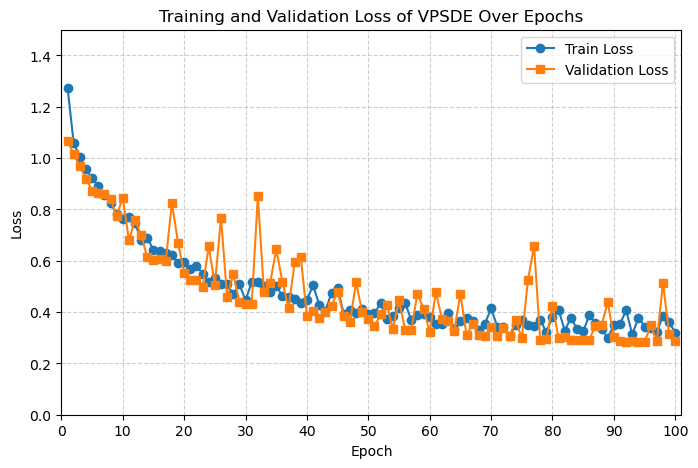

In [13]:
mport matplotlib.pyplot as plt


epochs = list(range(1, len(all_losses_train) + 1))


plt.figure(figsize=(8, 5))
plt.plot(epochs, all_losses_train, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, all_losses_valid, label="Validation Loss", marker="s", linestyle="-")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of VPSDE Over Epochs")
plt.ylim(0, 1.5)
plt.xlim(0,101)
plt.xticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()